# ECG - Arrythmia Classification - (Physionet - MIT-BIH )

In [15]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ECG

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ECG


In [16]:
pip install wfdb

In [17]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from scipy.signal import savgol_filter, find_peaks
from scipy.interpolate import interp1d
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

In [ ]:
# Define the Butterworth filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Parameters for the Butterworth filter
cutoff_frequency = 0.1  # Define an appropriate cutoff frequency
sampling_rate = 360  # Define the sampling rate of the ECG data
filter_order = 5  # Define the order of the filter

# AAMI heartbeat classification mapping based on MIT-BIH annotations
aami_mapping = {
    'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',  # Non-ectopic beats
    'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',             # Supraventricular ectopic beats
    'V': 'V', 'E': 'V', '!': 'V', '[': 'V', ']': 'V',   # Ventricular ectopic beats
    'F': 'F',                                           # Fusion beats
    '/': 'Q', 'f': 'Q', 'Q': 'Q'                        # Unknown beats
}

# Initialize lists to store processed data
all_heartbeats = []
all_labels = []

# Define the file IDs for records to process
file_ids = [str(x) for x in [100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
                             111, 112, 113, 114, 115, 116, 117, 118, 119,
                             121, 122, 123, 124,
                             200, 201, 202, 203, 205, 207, 208, 209, 210,
                             212, 213, 214, 215, 217, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234]]

# Process each ECG record
for file_id in file_ids:
    record_name = file_id
    try:
        # Load ECG data and annotations
        signals, fields = wfdb.rdsamp(record_name, sampfrom=0, channels=[0])
        annotation = wfdb.rdann(record_name, 'atr')

        # Find R-peaks in the ECG signal (assuming normal ECG signal without filtering)
        r_peaks, _ = find_peaks(signals[:, 0], distance=fields['fs']*0.6)

        # Extract heartbeats based on R-peaks
        for r_peak in r_peaks:
            start, end = r_peak - 128, r_peak + 108
            if start >= 0 and end <= len(signals):
                heartbeat = signals[start:end, 0]
                all_heartbeats.append(heartbeat)

                # Find the closest annotation to the R-peak
                annotation_index = np.argmin(np.abs(annotation.sample - r_peak))
                symbol = annotation.symbol[annotation_index]
                all_labels.append(symbol)

    except FileNotFoundError:
        print(f"File '{record_name}' not found. Skipping...")

# Map the annotations to AAMI classes and count them
aami_label_counts = Counter()
for symbol in all_labels:
    if symbol in aami_mapping:
        aami_class = aami_mapping[symbol]
        aami_label_counts[aami_class] += 1

# Print the count for each AAMI class
print("AAMI Label Counts after categorization:")
for aami_class, count in aami_label_counts.items():
    print(f"{aami_class}: {count}")

# Print the total number of heartbeats categorized
print(f"Total number of heartbeats categorized: {len(all_heartbeats)}")

AAMI Label Counts after categorization:
N: 87326
S: 2651
V: 6103
Q: 8042
F: 782
Total number of heartbeats categorized: 105750


# **Data Collection**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ECG

# **Data Segmentation**

In [18]:

for record_number in [100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
                             111, 112, 113, 114, 115, 116, 117, 118, 119,
                             121, 122, 123, 124,
                             200, 201, 202, 203, 205, 207, 208, 209, 210,
                             212, 213, 214, 215, 217, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234]:

    record_name = str(record_number)
    try:
        # Load ECG data from the .dat file
        record = wfdb.rdrecord(record_name)
        ecg_data = record.p_signal[:, 0]


        # Load annotations from the .atr file
        annotation = wfdb.rdann(record_name, atr_file_extension)


        # Normalize the ECG signal to the range [0, 1]
        ecg_data = normalize_data(ecg_data)

        # Find R-peaks in the ECG signal
        r_peaks, _ = find_peaks(ecg_data, height=0.2, distance=200)

        for r_peak in r_peaks:
            total_rpeaks = total_rpeaks + 1
            # Determine the annotation label for the current R-peak
            annotation_indices = np.where(annotation.sample == r_peak)[0]

            if annotation_indices.size > 0:
                # Use the first matching annotation index
                annotation_index = annotation_indices[0]
                annotation_label = annotation.symbol[annotation_index]


            start = r_peak - 200
            end = r_peak + 200
            if start < 0 or end >= len(ecg_data):
                continue

            heartbeat_segment = ecg_data[start:end]
            heartbeats.append(heartbeat_segment)
            labels.append(annotation_label)

        aami_categories = {'N': [], 'S': [], 'V': [], 'F': [], 'Q': []}

        for i in range(len(heartbeats)):
            annotation_l = labels[i]
            heartbeat = heartbeats[i]

            if annotation_l in ['N', 'L', 'R', 'e', 'j']:
                aami_categories['N'].append(heartbeat)

            elif annotation_l in ['V', 'E']:
                aami_categories['V'].append(heartbeat)

            elif annotation_l in ['A', 'a', 'J', 'S']:
                aami_categories['S'].append(heartbeat)

            elif annotation_l == 'F':
                aami_categories['F'].append(heartbeat)

            elif annotation_l in ['P', '/', 'f', 'Q', 'U']:
                aami_categories['Q'].append(heartbeat)

            else:
                continue

    except FileNotFoundError:
        # Handle the case where the file does not exist
        print(f"File '{record_name}' not found. Skipping...")


In [19]:
# Loop through the AAMI categories and print the counts
total = 0
for category, heartbeats in aami_categories.items():
    count = len(heartbeats)
    print(f'Category {category}: {count} heartbeats')
    total = total + count

print(f'Total segments from all Category {total}')


Category N: 95666 heartbeats
Category S: 2485 heartbeats
Category V: 8344 heartbeats
Category F: 512 heartbeats
Category Q: 4292 heartbeats
Total segments from all Category 111299


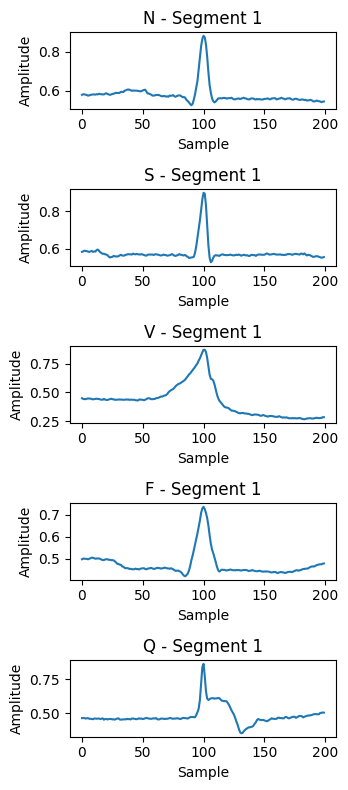

AAMI Class Type: N, Number of Segments: 95696
AAMI Class Type: S, Number of Segments: 2486
AAMI Class Type: V, Number of Segments: 8347
AAMI Class Type: F, Number of Segments: 512
AAMI Class Type: Q, Number of Segments: 4294


In [ ]:
# Define a dictionary to count the number of segments for each annotation type
num_segments_per_category = {}

# Create a single figure for all annotation types
plt.figure(figsize=(15, 8))

# Visualize each type of annotation
for i, (aami_label, segments) in enumerate(aami_categories.items()):
    num_segments = len(segments)
    num_segments_per_category[aami_label] = num_segments

    for j, segment in enumerate(segments[:1]):
        plt.subplot(5, len(aami_categories), i * 5 + j + 1)
        plt.plot(segment)
        plt.title(f'{aami_label} - Segment {j + 1}')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

# Print the number of segments for each annotation type
for aami_label, num_segments in num_segments_per_category.items():
    if(aami_label == 'S'):
        num_seg_s = num_segments
    elif(aami_label == 'F'):
        num_seg_f = num_segments
    elif(aami_label == 'N'):
        num_seg_n = num_segments
    elif(aami_label == 'V'):
        num_seg_v = num_segments
    elif(aami_label == 'Q'):
        num_seg_q = num_segments

    print(f'AAMI Class Type: {aami_label}, Number of Segments: {num_segments}')

# Data sampling to balance data using oversampling

In [20]:
# Split the data into training (70%), validation (15%), and test (15%) sets
X = []  # Features
y = []  # Target variable

for category, heartbeats in aami_categories.items():
    if heartbeats:
        # Append the features and labels
        X.extend(heartbeats)
        y.extend([category] * len(heartbeats))

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

In [21]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [19]:
print("X_train_reshaped shape:", X_train.shape)
print("y_train_encoded shape:", y_train.shape)
print("X_val_reshaped shape:", X_val.shape)
print("y_val_encoded shape:", y_val.shape)


X_train_reshaped shape: (77909, 400)
y_train_encoded shape: (77909,)
X_val_reshaped shape: (16695, 400)
y_val_encoded shape: (16695,)


# **CNN-LSTM-Transformer Model**

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, GlobalAveragePooling1D, Add, Dropout, LayerNormalization
import tensorflow as tf

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, head_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.head_size = head_size
        self.num_heads = num_heads
        self.attention = tf.keras.layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=0.1
        )
        self.layer_norm = LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        attention_output = self.attention(inputs, inputs)
        x = self.layer_norm(inputs + attention_output)
        return x

# Define the input layer
input_shape = (200, 1)
input_layer = Input(shape=input_shape)

# 1D CNN layer
cnn_output = Conv1D(filters=64, kernel_size=5, activation='relu')(input_layer)

# LSTM layer
lstm_output = LSTM(64, return_sequences=True)(cnn_output)

# Transformer Encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadSelfAttention(head_size=head_size, num_heads=num_heads)(x)
    x = Dropout(dropout)(x)
    res = Add()([inputs, x])

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return Add()([res, x])
transformer_output = transformer_encoder(lstm_output, 64, 2, 64, 0.1)

# Global Average Pooling
global_avg_pooling = GlobalAveragePooling1D()(transformer_output)

# Dense layer for classification
output_layer = Dense(5, activation='softmax')(global_avg_pooling)

# Build the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 196, 64)              384       ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, 196, 64)              33024     ['conv1d[0][0]']              
                                                                                                  
 layer_normalization (Layer  (None, 196, 64)              128       ['lstm[0][0]']                
 Normalization)                                                                               

# **Model Evaluation**

Epoch 1/10
2435/2435 [==============================] - 280s 113ms/step - loss: 0.5218 - accuracy: 0.8597 - val_loss: 0.4133 - val_accuracy: 0.8766
Epoch 2/10
2435/2435 [==============================] - 264s 109ms/step - loss: 0.3779 - accuracy: 0.8864 - val_loss: 0.3476 - val_accuracy: 0.8951
Epoch 3/10
2435/2435 [==============================] - 261s 107ms/step - loss: 0.3455 - accuracy: 0.8941 - val_loss: 0.3576 - val_accuracy: 0.8897
Epoch 4/10
2435/2435 [==============================] - 259s 106ms/step - loss: 0.3248 - accuracy: 0.8979 - val_loss: 0.3141 - val_accuracy: 0.9016
Epoch 5/10
2435/2435 [==============================] - 262s 107ms/step - loss: 0.3048 - accuracy: 0.9036 - val_loss: 0.2956 - val_accuracy: 0.9078
Epoch 6/10
2435/2435 [==============================] - 259s 106ms/step - loss: 0.2898 - accuracy: 0.9066 - val_loss: 0.2967 - val_accuracy: 0.9039
Epoch 7/10
2435/2435 [==============================] - 258s 106ms/step - loss: 0.2782 - accuracy: 0.9095 - val_

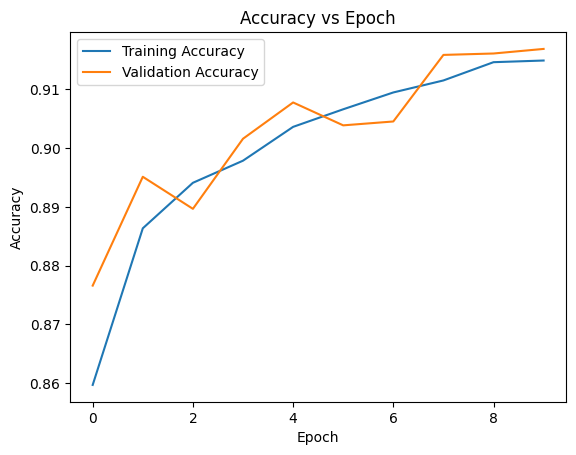

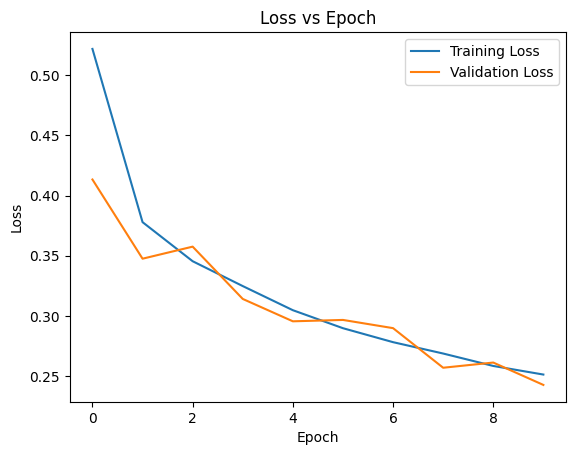

522/522 [==============================] - 18s 34ms/step - loss: 0.2454 - accuracy: 0.9156
Test Loss: 0.24537886679172516, Test Accuracy: 0.9156034588813782


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, GlobalAveragePooling1D, Add, Dropout, LayerNormalization
import tensorflow as tf
import tensorflow as tf

# Clear TensorFlow session
tf.keras.backend.clear_session()

# Assuming you have your data split as follows:
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to one-hot encoding
label_binarizer = LabelBinarizer()
y_train_encoded = label_binarizer.fit_transform(y_train)
y_val_encoded = label_binarizer.transform(y_val)
# Assuming you're downsampling by 2
# Assuming your original data has shape (samples, features) and you want a window size of 200
window_size = 200

# Reshape the data to have a window size of 200
X_train_reshaped = X_train[:, :window_size].reshape(-1, window_size, 1)
X_val_reshaped = X_val[:, :window_size].reshape(-1, window_size, 1)
X_test_reshaped = X_test[:, :window_size].reshape(-1, window_size, 1)

# Now, you can use X_train_reshaped, X_val_reshaped, and X_test_reshaped in the fit method
history = model.fit(
    X_train_reshaped, y_train_encoded,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val_encoded)
)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

# Plot loss vs epoch for both training and validation sets
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

# Evaluate the model on the reshaped test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, label_binarizer.transform(y_test))
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


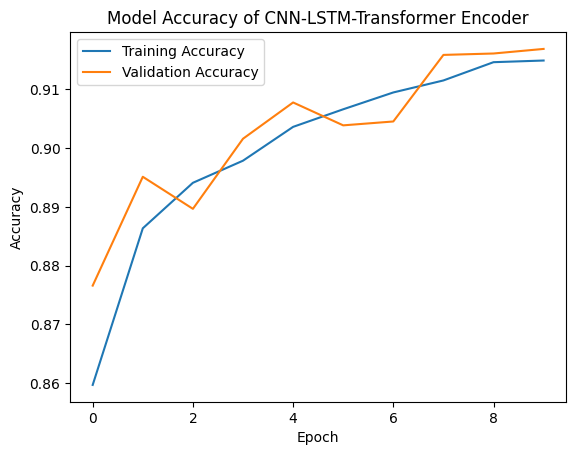

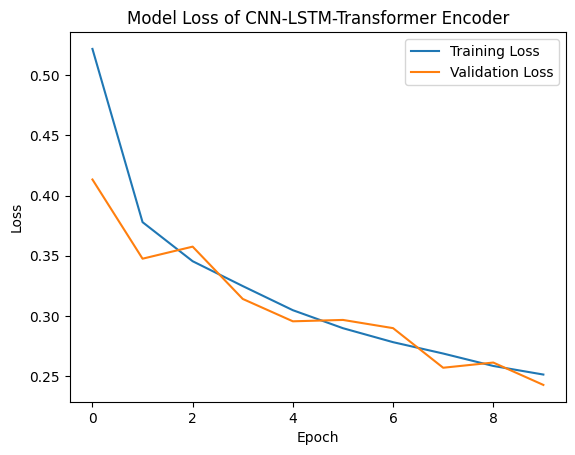

In [24]:
import matplotlib.pyplot as plt

def plot_metric(history, metric, label, ylabel, title):
    plt.plot(history.history[metric], label=f'Training {label}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {label}')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Plot accuracy vs epoch for both training and validation sets
plot_metric(history, 'accuracy', 'Accuracy', 'Accuracy', 'Model Accuracy of CNN-LSTM-Transformer Encoder')

# Plot loss vs epoch for both training and validation sets
plot_metric(history, 'loss', 'Loss', 'Loss', 'Model Loss of CNN-LSTM-Transformer Encoder')


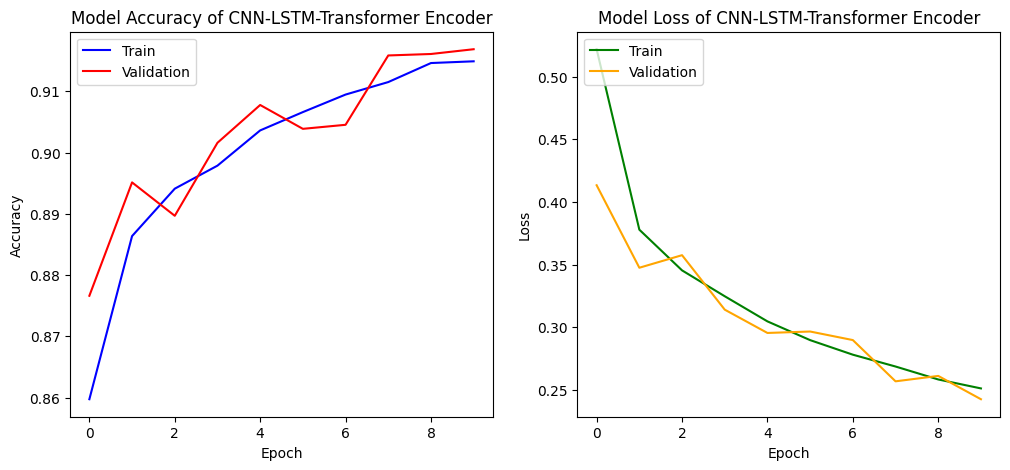

In [25]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='blue', label='Train')
plt.plot(history.history['val_accuracy'], color='red', label='Validation')
plt.title('Model Accuracy of CNN-LSTM-Transformer Encoder')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='green', label='Train')
plt.plot(history.history['val_loss'], color='orange', label='Validation')
plt.title('Model Loss of CNN-LSTM-Transformer Encoder')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

In [1]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


NameError: ignored

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, GlobalAveragePooling1D, Add, Dropout, LayerNormalization
import tensorflow as tf  # Add this import for MultiHeadAttention
from tensorflow.keras.layers import Bidirectional


class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, head_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.head_size = head_size
        self.num_heads = num_heads
        self.attention = tf.keras.layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=0.1
        )
        self.layer_norm = LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        attention_output = self.attention(inputs, inputs)
        x = self.layer_norm(inputs + attention_output)
        return x

# Define the input layer
input_shape = (200, 1)
input_layer = Input(shape=input_shape)

# 1D CNN layer
cnn_output = Conv1D(filters=64, kernel_size=5, activation='relu')(input_layer)
cnn_output_2 = Conv1D(filters=32, kernel_size=5, activation='relu')(cnn_output)


# LSTM layer
lstm_output = Bidirectional(LSTM(64, return_sequences=True))(cnn_output_2)


# Transformer Encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadSelfAttention(head_size=head_size, num_heads=num_heads)(x)  # Corrected this line
    x = Dropout(dropout)(x)
    res = Add()([inputs, x])

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return Add()([res, x])

transformer_output = transformer_encoder(lstm_output, 64, 2, 64, 0.1)

# Global Average Pooling
global_avg_pooling = GlobalAveragePooling1D()(transformer_output)

# Dense layer for classification
output_layer = Dense(5, activation='softmax')(global_avg_pooling)  # Assuming 5 classes (N, S, V, F, Q)

# Build the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 conv1d_4 (Conv1D)           (None, 196, 64)              384       ['input_2[0][0]']             
                                                                                                  
 conv1d_5 (Conv1D)           (None, 192, 32)              10272     ['conv1d_4[0][0]']            
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 192, 128)             49664     ['conv1d_5[0][0]']            
 onal)                                                                                        

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, GlobalAveragePooling1D, Add, Dropout, LayerNormalization
import tensorflow as tf
import tensorflow as tf

# Clear TensorFlow session
tf.keras.backend.clear_session()

# Assuming you have your data split as follows:
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to one-hot encoding
label_binarizer = LabelBinarizer()
y_train_encoded = label_binarizer.fit_transform(y_train)
y_val_encoded = label_binarizer.transform(y_val)
# Assuming you're downsampling by 2
# Assuming your original data has shape (samples, features) and you want a window size of 200
window_size = 200

# Reshape the data to have a window size of 200
X_train_reshaped = X_train[:, :window_size].reshape(-1, window_size, 1)
X_val_reshaped = X_val[:, :window_size].reshape(-1, window_size, 1)
X_test_reshaped = X_test[:, :window_size].reshape(-1, window_size, 1)

# Now, you can use X_train_reshaped, X_val_reshaped, and X_test_reshaped in the fit method
history = model.fit(
    X_train_reshaped, y_train_encoded,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val_encoded)
)

# Evaluate the model on the reshaped test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, label_binarizer.transform(y_test))
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/10
2435/2435 [==============================] - 330s 134ms/step - loss: 0.4830 - accuracy: 0.8718 - val_loss: 0.4207 - val_accuracy: 0.8820
Epoch 2/10
2435/2435 [==============================] - 320s 131ms/step - loss: 0.3795 - accuracy: 0.8910 - val_loss: 0.3692 - val_accuracy: 0.8924
Epoch 3/10
2435/2435 [==============================] - 319s 131ms/step - loss: 0.3479 - accuracy: 0.8976 - val_loss: 0.3577 - val_accuracy: 0.8966
Epoch 4/10
2435/2435 [==============================] - 318s 131ms/step - loss: 0.4324 - accuracy: 0.8789 - val_loss: 0.3511 - val_accuracy: 0.8982
Epoch 5/10
2435/2435 [==============================] - 339s 139ms/step - loss: 0.3435 - accuracy: 0.8957 - val_loss: 0.3340 - val_accuracy: 0.9042
Epoch 6/10
2435/2435 [==============================] - 316s 130ms/step - loss: 0.3159 - accuracy: 0.9031 - val_loss: 0.3114 - val_accuracy: 0.9012
Epoch 7/10
2435/2435 [==============================] - 318s 130ms/step - loss: 0.2985 - accuracy: 0.9083 - val_

In [23]:
print("X_train_reshaped shape:", X_train.shape)
print("y_train_encoded shape:", y_train_encoded.shape)
print("X_val_reshaped shape:", X_val.shape)
print("y_val_encoded shape:", y_val_encoded.shape)


X_train_reshaped shape: (77909, 400)
y_train_encoded shape: (77909, 5)
X_val_reshaped shape: (16695, 400)
y_val_encoded shape: (16695, 5)


In [ ]:
X_samples = []  # Features
y_samples = []  # Target variable
categories_extracted = set()  # Keep track of categories for which samples have been extracted

for category, heartbeats in aami_categories.items():
    if heartbeats and category not in categories_extracted:
        # Append the features and labels
        X_samples.append(heartbeats[0])  # Extract the first sample for each category
        y_samples.append(category)
        categories_extracted.add(category)

# Convert to numpy arrays
X_samples = np.array(X_samples)
y_samples = np.array(y_samples)

df = pd.DataFrame(data=X_samples, columns=[f'value{i}' for i in range(1, X_samples.shape[1] + 1)])
df['label'] = y_samples

# Save the entire dataset to a CSV file
df.to_csv('sample.csv', index=False)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# Assuming you have X and y as your input features and target variables

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape your input data to (batch_size, sequence_length, input_dim)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Define the CNN part of the model
cnn_input = layers.Input(shape=(X_train.shape[1], 1))
cnn_output = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
cnn_output = layers.MaxPooling1D(pool_size=2)(cnn_output)
cnn_output = layers.Flatten()(cnn_output)

# Define the Transformer part of the model
transformer_input = layers.Input(shape=(X_train.shape[1], 1))
transformer_output = layers.MultiHeadAttention(num_heads=4, key_dim=4)(transformer_input, transformer_input)
transformer_output = layers.GlobalAveragePooling1D()(transformer_output)

# Concatenate the outputs of CNN and Transformer
combined_output = layers.Concatenate()([cnn_output, transformer_output])

# Add a Dense layer for classification
dense_output = layers.Dense(128, activation='relu')(combined_output)
output = layers.Dense(5, activation='softmax')(dense_output)

# Create the model
model = keras.Model(inputs=[cnn_input, transformer_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit([X_train, X_train], y_train, epochs=10, validation_data=([X_val, X_val], y_val))


Epoch 1/10


UnimplementedError: ignored